# Plotting animated GIFs from time series imagery

**What does this notebook do?** 

This notebook demonstrates how to import a time series of DEA cloud-free Landsat imagery from multiple sensors (i.e. Landsat 5, 7 and 8) as an xarray dataset, and then plot the data as an animated time series GIF and a transitioning/fading GIF that compares two timesteps. Animations can be produced as either GIFs or MP4s for any area in Australia using a standard datacube query.

**Required inputs**

This example uses three external functions called `load_clearlandsat`, `animated_timeseries` and `animated_fade`. These functions are available in the Scripts folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** May 2018

**Author:** Robbi Bishop-Taylor

In [4]:
# Import modules
import datacube 
import sys
import os

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../Scripts')
import DEADataHandling
import DEAPlotting

# Set up datacube instance
dc = datacube.Datacube(app='Time series animation')

## Set up datacube query
Define the query bounds for datacube extraction using a dict. This should include `x` and `y` limits, potentially a list of `measurements` (i.e. the bands you want to extract like 'red', 'green', 'blue'; this significantly speeds up the import) and a `time` extent. If no `time` is given, the function defaults to all timesteps available to all sensors (e.g. 1987-2018).

In [6]:
# Set up spatial and temporal query.
query = {'x': (970476, 987476),
         'y': (-3568950, -3551951),
         'measurements': ['red', 'green', 'blue'],
         'time': ('2013-01-01', '2018-01-01'),
         'crs': 'EPSG:3577'}

## Extract cloud-free clear Landsat observations from all sensors
Use the `load_clearlandsat` function to load Landsat observations and PQ data for multiple sensors (i.e. ls5, ls7, ls8), and return a single xarray dataset containing only observations that contain greater than a specified proportion of clear pixels. This uses `dask` to only load in the filtered observations, and results in a visually appealing time series of observations that are not affected by cloud!

<xarray.Dataset>
Dimensions:    (time: 55, x: 680, y: 680)
Coordinates:
  * y          (y) float64 -3.552e+06 -3.552e+06 -3.552e+06 -3.552e+06 ...
  * x          (x) float64 9.705e+05 9.705e+05 9.705e+05 9.706e+05 9.706e+05 ...
  * time       (time) datetime64[ns] 2013-04-03T00:22:12 2013-04-22T00:22:11 ...
Data variables:
    red        (time, y, x) float64 838.0 909.0 1.074e+03 1.15e+03 1.253e+03 ...
    green      (time, y, x) float64 682.0 712.0 788.0 819.0 876.0 893.0 ...
    blue       (time, y, x) float64 574.0 583.0 596.0 596.0 608.0 617.0 ...
    data_perc  (time) float64 1.0 1.0 0.9997 0.9994 0.9998 1.0 1.0 1.0 1.0 ...
Attributes:
    crs:      EPSG:3577


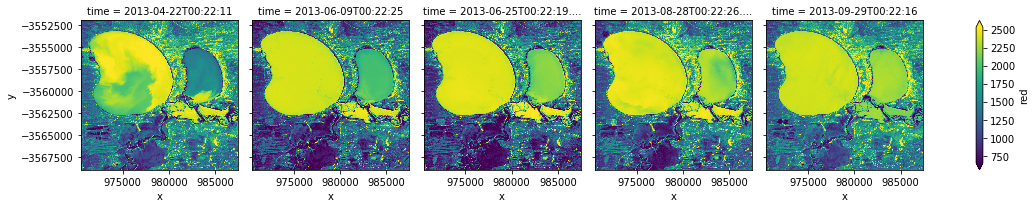

In [30]:
# Set the minimum proportion of clear pixels (pixels with no clouds or other nodata)
masked_prop=0.99

# Load in only clear Landsat observations with < 1% unclear values
combined_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, masked_prop=masked_prop)  
print(combined_ds)

# Plot first five time series images (just using the red band for simplicity):
combined_ds.red.isel(time=[1, 2, 3, 4, 5]).plot(col="time", robust=True)

## Plot entire time series as an animated GIF
The `animated_timeseries` function takes an xarray time series and exports a three band (e.g. true or false colour) GIF or MP4 animation showing changes in the landscape across time. Here, we plot the xarray as an animated GIF that includes a date annotation for each frame. We set the interval between the animation frames to 80 milliseconds, and set `reflect_stand=2500` to use a bright and vibrant colour stretch:

Generating animation with 55 frames
    Exporting animation to animated_timeseries.gif


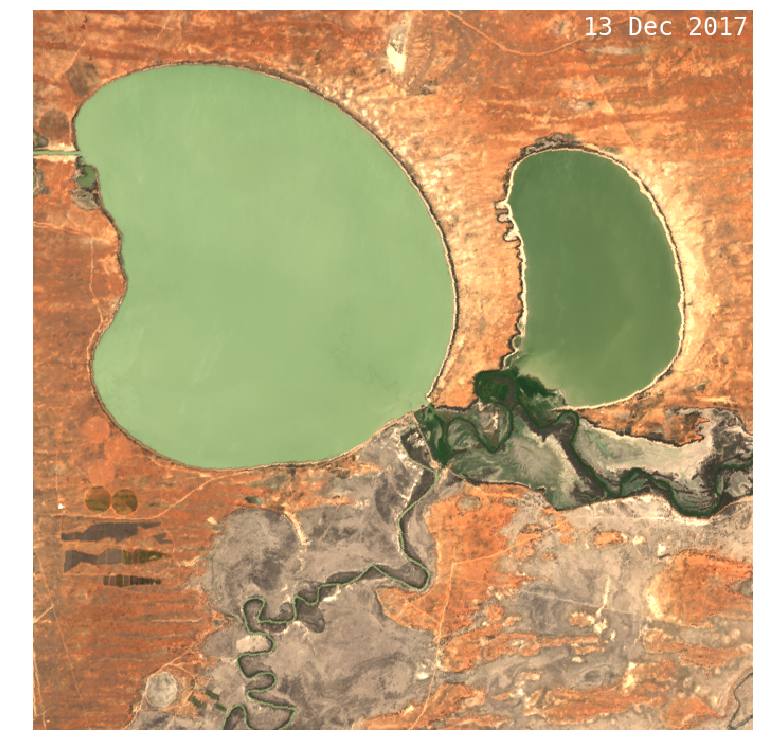

In [11]:
# Produce time series animation of red, green and blue bands
DEAPlotting.animated_timeseries(ds=combined_ds, output_path="animated_timeseries.gif", 
                                interval=80, reflect_stand=2500) 

## Plot fading/transitioning animation to compare two timesteps
The `animated_fade` function takes two single-timestep xarray datasets, and plots an animation of the two layers fading between each other. This may be useful for comparing an area before and after environmental change (i.e. flood, drought, fire, development), or comparing two different geographic areas. Here, we compare a dry and a wet timestep, and use the `endpoint_text` parameter to annotate the two images:

Exporting animation to animated_fade.gif


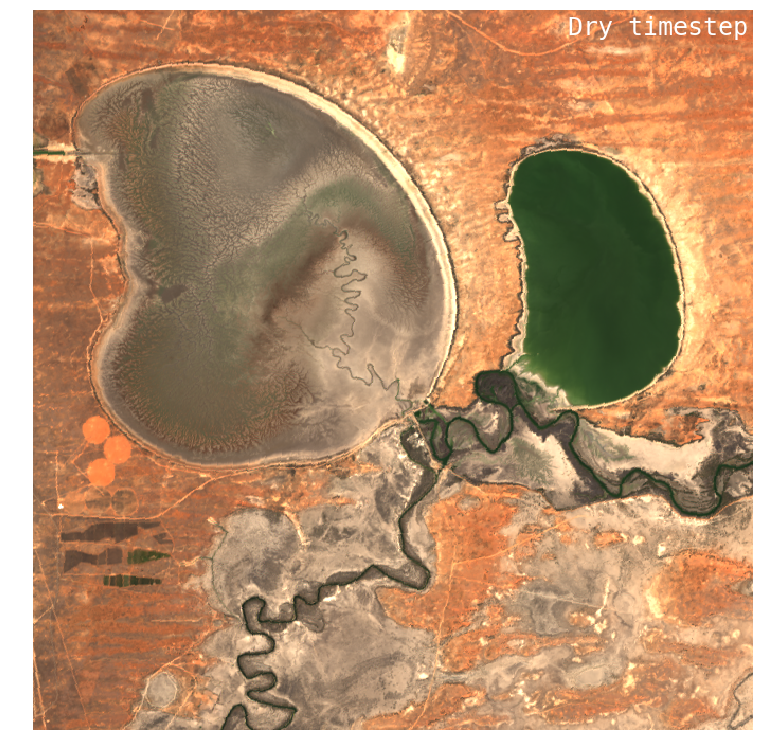

In [13]:
# Extract xarray datasets for two timesteps
ds1 = combined_ds.isel(time=1)
ds2 = combined_ds.isel(time=30)

# Produce animation that fades between ds1 and ds2
DEAPlotting.animated_fade(ds1=ds1, ds2=ds2, 
                          output_path='animated_fade.gif', 
                          reflect_stand=2500,
                          endpoint_text=['Dry timestep',  'Wet timestep'])